In [38]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define Classes

In [2]:
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "Add",
    "Decimal",
    "Division",
    "Equals",
    "Multiply",
    "Minus",
    "X",
    "Y",
    "Z",
]

# Load Model

In [3]:

model = tf.keras.models.load_model("models/19_class.h5")

2022-01-02 05:44:42.908887: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helper Function

In [4]:
def show_img(img):
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    
    
def show_images(images, title=''):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i+1)
        plt.imshow(image)
        plt.title(title)
    
    
def show_prediction(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255

    predictions = model.predict(image)
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    
    return label,confidence

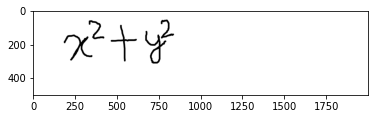

In [5]:
img_path = 'test_cases/poly.png'
image = cv.imread(img_path)
show_img(image)

# Do some preprocessing

In [6]:
gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
edged = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 11, 4)
(contours, _) = cv.findContours(edged, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

# Find Bounding box using Contours 

In [7]:
chars_bb = []
for contour in contours:
            contour = contour.reshape((contour.shape[0],contour.shape[2]))
            left_tc = np.amin(contour, axis=0)
            right_bc = np.amax(contour, axis=0)
            min_x = left_tc[0]
            max_x = right_bc[0]
            min_y = left_tc[1]
            max_y = right_bc[1]
            chars_bb.append([min_x,min_y,max_x,max_y])

# Show bounding box

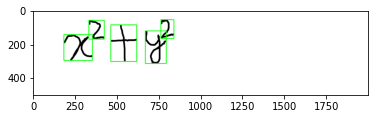

In [8]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),3)
    #print(box)
    
show_img(copy)

# Replacing Double Minus as EqualsTo

Note even though this logic should repalce most double minus with
equals to we still need further logic to explicitly convert two 
consecutive minus as equals

In [9]:
chars_bb.sort()

for i, box in enumerate(chars_bb):
    try:
         next_box = chars_bb[i+1]
    except IndexError:
        break
   
    if abs(box[0] - next_box[0]) <= 30:
        min_x = min(box[0],next_box[0])
        min_y = min(box[1],next_box[1])
        max_x = max(box[2],next_box[2])
        max_y = max(box[3],next_box[3])
        new_box = [min_x,min_y,max_x,max_y]
        chars_bb[i] = new_box
        chars_bb.remove(next_box)
        
        

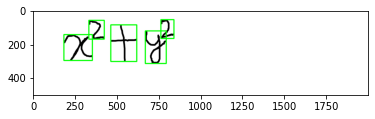

In [45]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
    
show_img(copy)

# Calssify if image is superscript or not

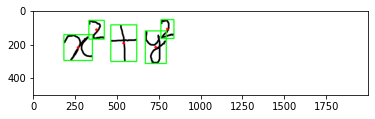

In [46]:
copy = image.copy()
centroid_Y = []
for i, box in enumerate(chars_bb):
   centroidX, centroidY = (int((box[0]+box[2])/2),int((box[1]+box[3])/2))
   cv.circle(copy, center=(centroidX, centroidY), radius=5, color=(255, 0, 0), thickness=5)
   cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
   centroid_Y.append(centroidY)
show_img(copy)


In [53]:
def classify_super(points):
    is_super = {}
    mean = np.mean(points)
    for i,point in enumerate(points):
        if point > mean:
            is_super[i] = 'base'
        else:
            is_super[i] = 'super'
    return is_super

print(classify_super(centroid_Y))

{0: 'base', 1: 'super', 2: 'base', 3: 'base', 4: 'super'}


# Crop the Images

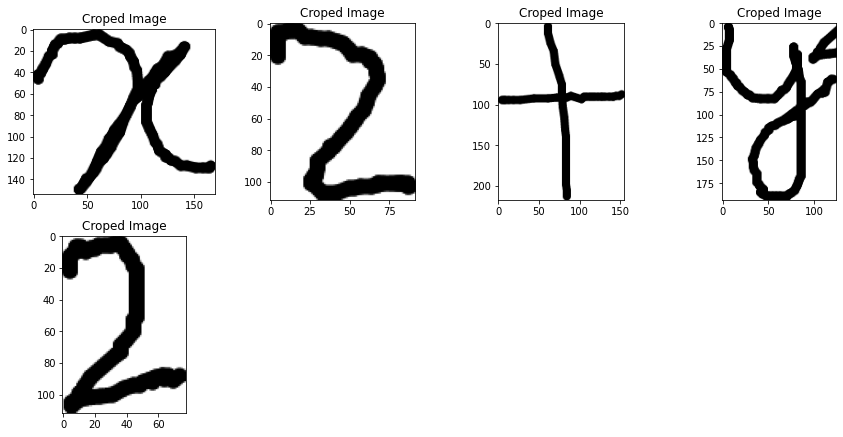

In [11]:
croped_images = []
copy = image.copy()
for box in chars_bb:
    x_min = box[0]
    y_min = box[1]
    height = abs(box[0]-box[2])
    width = abs(box[1]-box[3])
    character = copy[y_min:y_min+width , x_min:x_min+height]
    croped_images.append(character)
    
show_images(croped_images, title='Croped Image')

In [12]:
def extra_padding(img, padding=50):
    return cv.copyMakeBorder(img, top=padding, bottom=padding, left=padding, right=padding, borderType=cv.BORDER_CONSTANT, value=(255,255,255))

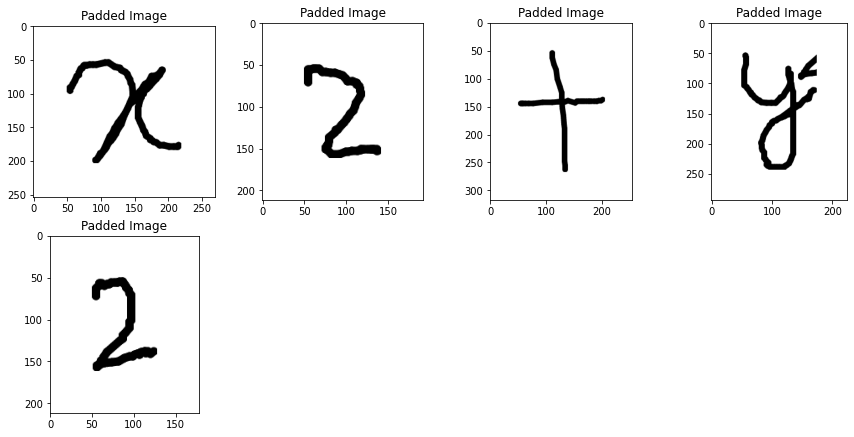

In [13]:
padded_images = []
for img in croped_images:
    padded_img = extra_padding(img)
    padded_images.append(padded_img)

show_images(padded_images, title='Padded Image')

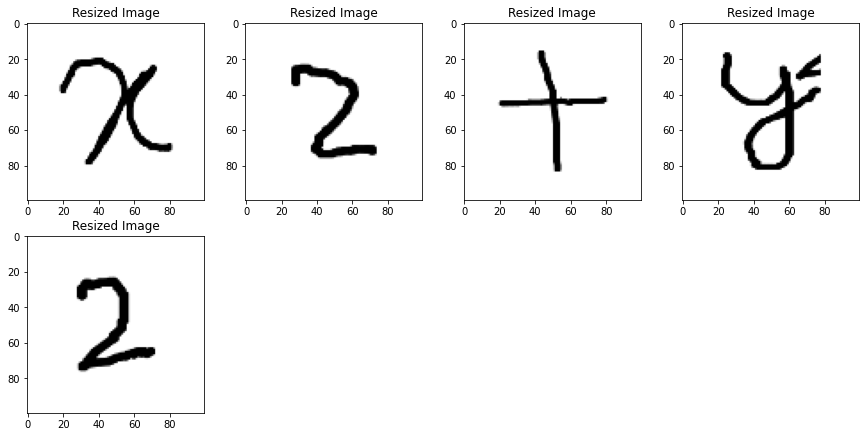

In [14]:
resized_images = []
for img in padded_images:
    resized_img = cv.resize(img, (100, 100), interpolation=cv.INTER_LINEAR)
    resized_images.append(resized_img)

show_images(resized_images, title='Resized Image')

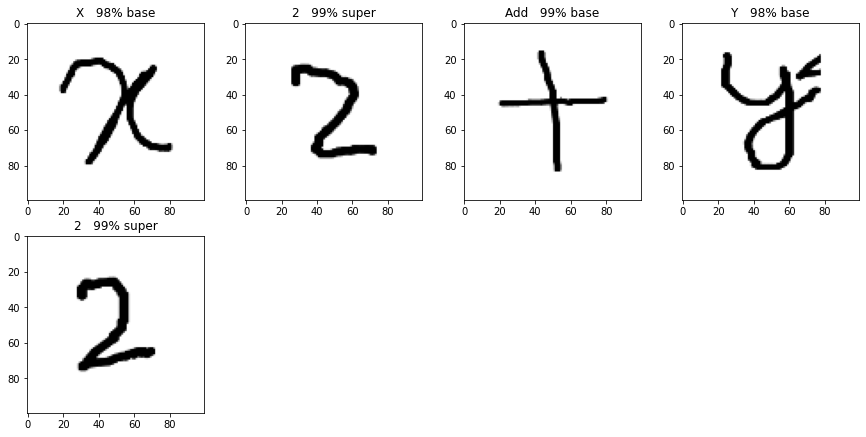

In [55]:
is_super = classify_super(centroid_Y)
plt.figure(figsize=(15, 15))
for i, img in enumerate(resized_images):
    label, conf = show_prediction(img)
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    title = label+'   '+ conf + '% ' + is_super[i]
    plt.title(title)
   